# <center> What makes a song a hit? 
    
### <center> Data Science in Practice
   <center> Authors: Sophie De Becker, Yao Di, Mattia Gallese, Giacomo Martiriggiano
    
   
    
  

Initial Imports

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
from sklearn import metrics
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Introduction
This is the jupyter notebook containing code used to complete the Data Science in Practice project. First a section is dedicated to how data is collected. Then an exploratory data analysis is carried out. Third, classification models are tested and finally a regression approach is explored.

## Collecting Data

The data used in this project wasn't readily available or pre-made. Effort was placed in finding a data source and compiling the information to generate 2 sets of data used in this project. 
1. Spotify Charts website was used to download csv files containing top 200 weekly rankings. The weekly ranking for each week in 2018 and 2019 were downloaded separately.
2. Each file was renamed by adding a number from 1 to 52 in chronological order at the end of the file name to allow for easy looping in python when needing to concatenate the data
3. Csv files were imported in Python and a dataframe was built using all the data collected

[The detailed process is described in the report]

The formatting of the csv file wasn't pandas friendly and so the following commands needed to be used to remove the non-relevant first row and replace the second rows of values as columns

### Don't run the following cells as it is the process used to build the final database used in the project

In [ ]:
df= pd.read_csv('regional-us-weekly-2018-1.csv')
df.columns = df.iloc[0]
df=df.drop(df.index[0])
df.index = np.arange(len(df))
df.head()

The original downloaded csv's only contined information regarding Position,Track Name,Artist,Streams and URL. In addition to combining all the weeks into a single data frame it was thus also necessary to collect feature vales using spotify's web API and a get command. 

In order to collect information the song id was needed, the url of the song was used and sliced to extract this information

In [ ]:
urlsong=df.loc[0, 'URL']
idsong=urlsong.partition('track/')[2]
getlink="https://api.spotify.com/v1/audio-features/" + idsong
print(getlink)

This procedure was done for one song in order to get the name of the future column values calling for dictionary keys. This would allow the data frame to later be populated

In [ ]:
client_id =  "e6c389f493e54752b303493e4955233f"
client_secret = "2364d7ce0600422eb3d479c61a0d018c"
grant_type = 'client_credentials'
body_params = {'grant_type' : grant_type}
url='https://accounts.spotify.com/api/token'
response=requests.post(url, data=body_params, auth = (client_id, client_secret)) 
token_raw = json.loads(response.text)
token = token_raw["access_token"]
headers = {"Authorization": "Bearer {}".format(token)}
response = requests.get(getlink, headers=headers)

newdict=response.json()
#getting values for columns/features
a=list(newdict.keys())
#b stores values that will be needed to fill rows of given song
b=list(newdict.values())
#initialize with empty columns
for i in a:
    df[i]=""
df.head()

Creating 2018 data set example is seen below, a similar code was used to generate 2019 data set

for j in range(0,53):
    df= pd.read_csv('regional-us-weekly-2018-%d.csv' %(j))
    df.columns = df.iloc[0]
    df=df.drop(df.index[0])
    df.index = np.arange(len(df))
    
    client_id =  "e6c389f493e54752b303493e4955233f"
    client_secret = "2364d7ce0600422eb3d479c61a0d018c"
    grant_type = 'client_credentials'
    body_params = {'grant_type' : grant_type}
    url='https://accounts.spotify.com/api/token'
    response=requests.post(url, data=body_params, auth = (client_id, client_secret)) 
    token_raw = json.loads(response.text)
    token = token_raw["access_token"]
    headers = {"Authorization": "Bearer {}".format(token)}
    urlsong=df.loc[0, 'URL']
    idsong=urlsong.partition('track/')[2]
    getlink="https://api.spotify.com/v1/audio-features/" + idsong

    response = requests.get(getlink, headers=headers)
    newdict=response.json()
    a=list(newdict.keys())
    b=list(newdict.values())
    for i in a:
        df[i]=""
    
    df['week']=''
    df['year']=''
    if j ==1:
        dftotal=pd.DataFrame(columns=df.columns)

    

    for r in df.index.values:
        urlsong=df.loc[r, 'URL']
        idsong=urlsong.partition('track/')[2]
        getlink="https://api.spotify.com/v1/audio-features/" + idsong
        response=requests.post(url, data=body_params, auth = (client_id, client_secret)) 
        token_raw = json.loads(response.text)
        token = token_raw["access_token"]
        headers = {"Authorization": "Bearer {}".format(token)}
        response = requests.get(getlink, headers=headers)


        newdict=response.json()
        a=list(newdict.keys())
        b=list(newdict.values())
        df.loc[r, a]=b
        df.loc[r,'week']=j
        df.loc[r,'year']=2018
        
    dftotal=pd.concat([dftotal, df], ignore_index=True)
    
#saving the finished concatenated 2018 csv file with all 52 weeks
dftotal.to_csv ('2018weekconcat.csv', index = False, header=True)

## Exploratory Data Analysis (Run from here)

In [2]:
#Importing the finished datasets
df18= pd.read_csv('2018weekconcat.csv')
df19= pd.read_csv('2019weekconcat.csv')
dfall=pd.concat([df18, df19], ignore_index=True)

### Initial Overview
Before looking for trends and patterns in time and amongst different categories we will first explore what the data looks like

In [3]:
# Checking there is no missing value
dfall.isnull().sum().sum()

0

In [4]:
#checking types of variables are consistent
dfall.dtypes

Position              int64
Track Name           object
Artist               object
Streams               int64
URL                  object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href           object
analysis_url         object
duration_ms           int64
time_signature        int64
week                  int64
year                  int64
dtype: object

We plot below the different distribution for certain song features for df18,df19 and dfALL (both combined). 

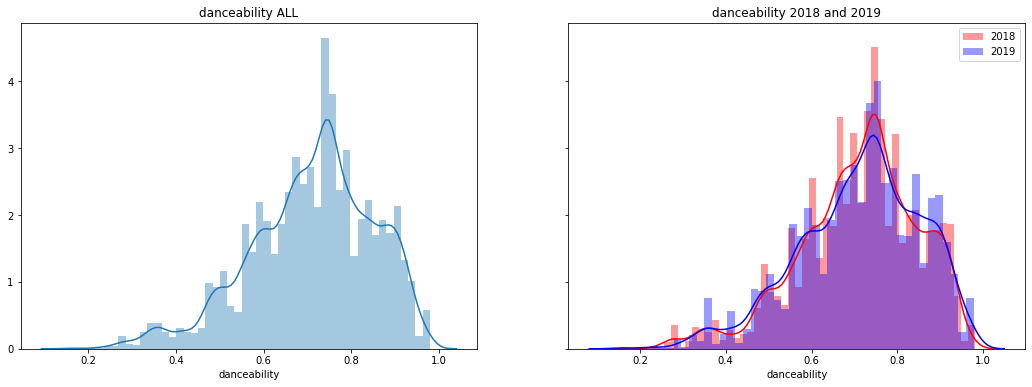

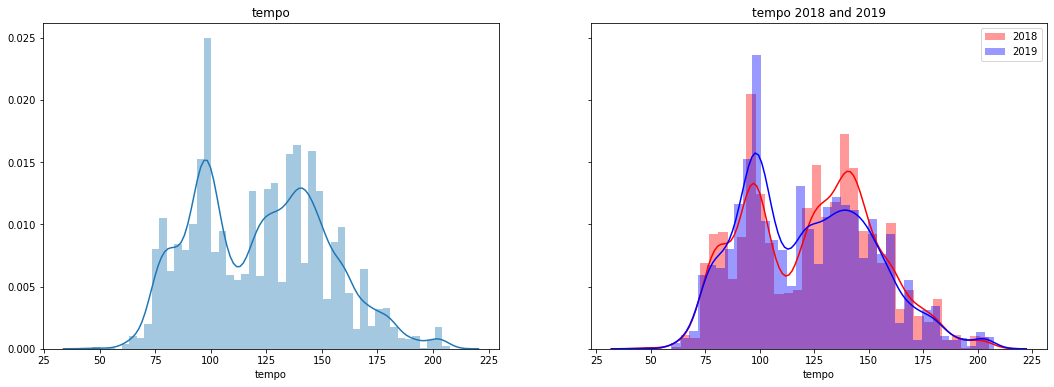

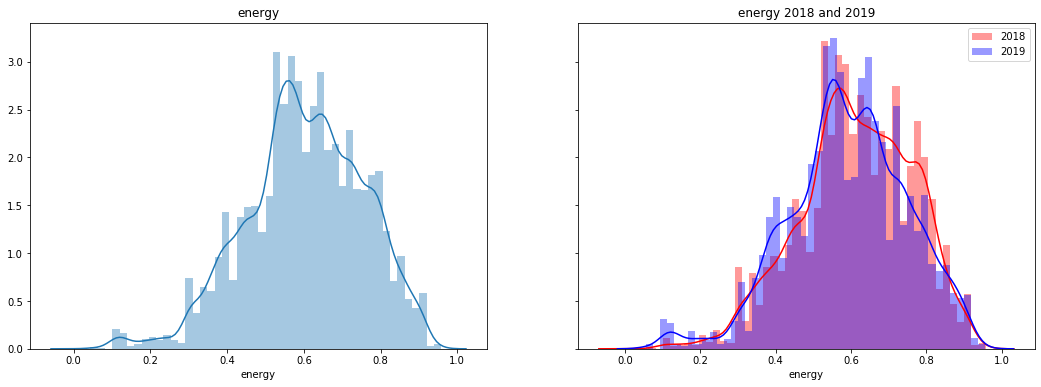

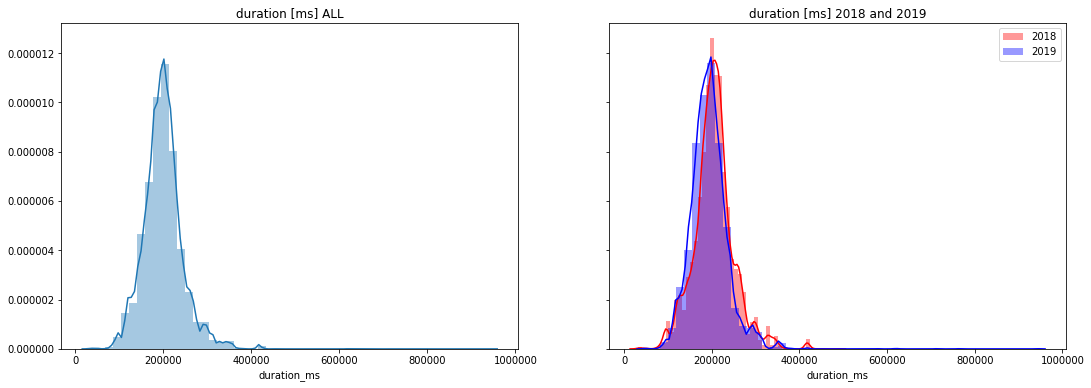

In [5]:
f1, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(18, 6))                                  

plt.sca(ax1)
sns.distplot(dfall['danceability'])
plt.title('danceability ALL')
plt.sca(ax2)
sns.distplot(df18['danceability'],color='r')
plt.title('danceability 2018 and 2019')
sns.distplot(df19['danceability'],color='b')
ax2.legend(['2018','2019'])

f1, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(18, 6))                                  

plt.sca(ax1)
sns.distplot(dfall['tempo'])
plt.title('tempo')
plt.sca(ax2)
sns.distplot(df18['tempo'],color='r')
plt.title('tempo 2018 and 2019')
sns.distplot(df19['tempo'],color='b')
ax2.legend(['2018','2019'])

f1, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(18, 6))                                  

plt.sca(ax1)
sns.distplot(dfall['energy'])
plt.title('energy')
plt.sca(ax2)
sns.distplot(df18['energy'],color='r')
plt.title('energy 2018 and 2019')
sns.distplot(df19['energy'],color='b')
ax2.legend(['2018','2019'])


f1, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(18, 6))                                  

plt.sca(ax1)
sns.distplot(dfall['duration_ms'])
plt.title('duration [ms] ALL')
plt.sca(ax2)
sns.distplot(df18['duration_ms'],color='r')
plt.title('duration [ms] 2018 and 2019')
sns.distplot(df19['duration_ms'],color='b')
ax2.legend(['2018','2019'])


The graphs above show that distributions are not exactly the same from one year to the next. This confirms that we were right to consider recent years for current song predictions. However taking two years still is beter to give us a larger pool of data and longer time to test if a song becomes succesful.

Now what if we do the same analysis but differentiate between top 10% (20 or above) song and average hit songs

### EDA with KPI 1
top if reaches above top 20, which means each week we recalculate if a song is top or not. This EDA is not useful for the classification part of the project since we switched to KPI2 to classify what is a top song or not.

In [6]:
df18['top'] = np.where(df18['Position']<21, 1, 0)
df19['top'] = np.where(df19['Position']<21, 1, 0)
dfall['top'] = np.where(dfall['Position']<21, 1, 0)

Some feature distributions were plotted to observe how the top and not top categories compare to one another

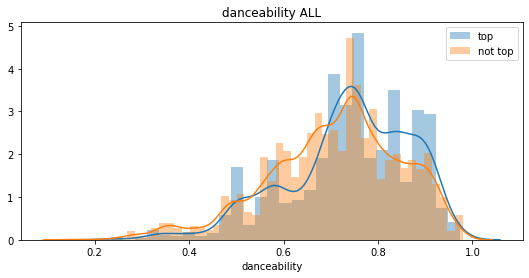

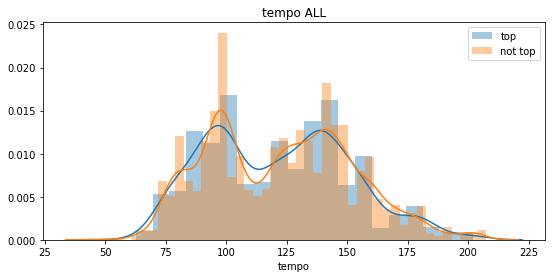

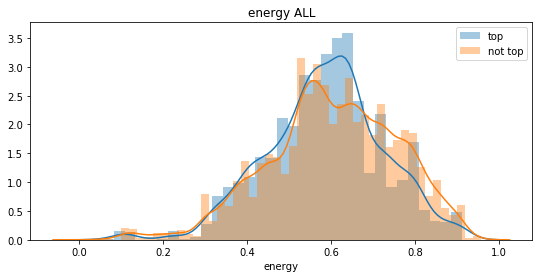

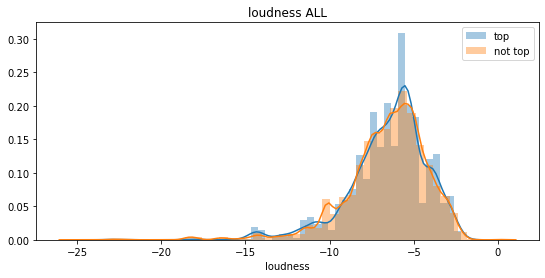

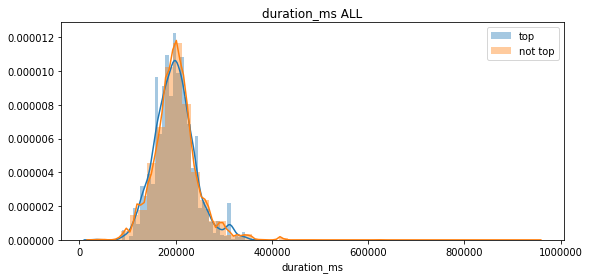

In [7]:
features=['danceability','tempo','energy','loudness','duration_ms']

for feat in features:
    f1, (ax1) = plt.subplots(1, 1, sharey=True,figsize=(9, 4))                                  

    plt.sca(ax1)
    df = dfall[dfall.top == 1]
    sns.distplot(df[feat], label='top')
    plt.title(feat + ' ALL')
    df = dfall[dfall.top == 0]
    sns.distplot(df[feat],label='not top')
    plt.legend()

    


## Exploring possible time patterns

Text(0, 0.5, 'danceability')

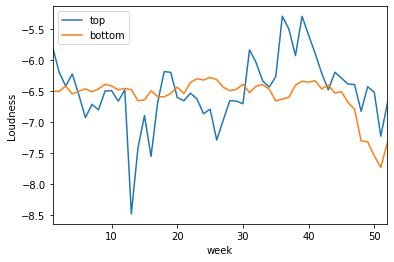

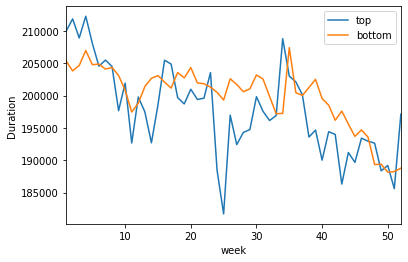

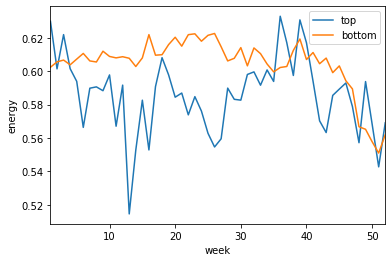

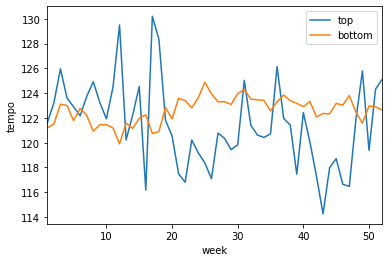

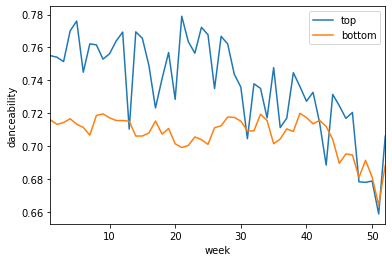

In [8]:

dfall_top=dfall[dfall['Position']<21]
dfall_bot=dfall[dfall['Position']>=21]

ax=dfall_top.groupby('week')['loudness'].mean().plot(kind='line')
ax=dfall_bot.groupby('week')['loudness'].mean().plot(kind='line')
plt.ylabel('Loudness')
ax.legend(["top", "bottom"])

plt.figure()
ax2=dfall_top.groupby('week')['duration_ms'].mean().plot(kind='line')
ax2=dfall_bot.groupby('week')['duration_ms'].mean().plot(kind='line')
plt.ylabel('Duration')
ax2.legend(["top", "bottom"])

plt.figure()
ax4=dfall_top.groupby('week')['energy'].mean().plot(kind='line')
ax4=dfall_bot.groupby('week')['energy'].mean().plot(kind='line')
ax4.legend(["top", "bottom"])
ax4.set_ylabel('energy')

plt.figure()
ax5=dfall_top.groupby('week')['tempo'].mean().plot(kind='line')
ax5=dfall_bot.groupby('week')['tempo'].mean().plot(kind='line')
ax5.legend(["top", "bottom"])
ax5.set_ylabel('tempo')

plt.figure()
ax5=dfall_top.groupby('week')['danceability'].mean().plot(kind='line')
ax5=dfall_bot.groupby('week')['danceability'].mean().plot(kind='line')
ax5.legend(["top", "bottom"])
ax5.set_ylabel('danceability')

### EDA with KPI 2
a new 'top' definition is now used in this section: top if number it reached top 20 (was a top) in at least one week


In [9]:
#define nondup
dfall['top'] = np.where(dfall['Position']<21, 1, 0)
dfallnondup=dfall.sort_values('Position', ascending=True).drop_duplicates('Track Name')
dfallnondup.index = np.arange(len(dfallnondup))
dfallnondup.head()

,Position,Track Name,Artist,Streams,URL,danceability,energy,key,loudness,mode,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,week,year,top
0,1,rockstar,Post Malone,9855305,https://open.spotify.com/track/7wGoVu4Dady5GV0...,0.577,0.522,5,-6.594,0,...,audio_features,7wGoVu4Dady5GV0Sv4UIsx,spotify:track:7wGoVu4Dady5GV0Sv4UIsx,https://api.spotify.com/v1/tracks/7wGoVu4Dady5...,https://api.spotify.com/v1/audio-analysis/7wGo...,218320,4,1,2018,1
1,1,Nice For What,Drake,19830250,https://open.spotify.com/track/1cTZMwcBJT0Ka3U...,0.567,0.913,8,-6.471,1,...,audio_features,1cTZMwcBJT0Ka3UJPXOeeN,spotify:track:1cTZMwcBJT0Ka3UJPXOeeN,https://api.spotify.com/v1/tracks/1cTZMwcBJT0K...,https://api.spotify.com/v1/audio-analysis/1cTZ...,210926,4,15,2018,1
2,1,Circles,Post Malone,12719540,https://open.spotify.com/track/21jGcNKet2qwijl...,0.695,0.762,0,-3.497,1,...,audio_features,21jGcNKet2qwijlDFuPiPb,spotify:track:21jGcNKet2qwijlDFuPiPb,https://api.spotify.com/v1/tracks/21jGcNKet2qw...,https://api.spotify.com/v1/audio-analysis/21jG...,215280,4,37,2019,1
3,1,Better Now,Post Malone,21229827,https://open.spotify.com/track/7dt6x5M1jzdTEt8...,0.680,0.578,10,-5.804,1,...,audio_features,7dt6x5M1jzdTEt8oCbisTK,spotify:track:7dt6x5M1jzdTEt8oCbisTK,https://api.spotify.com/v1/tracks/7dt6x5M1jzdT...,https://api.spotify.com/v1/audio-analysis/7dt6...,231267,4,17,2018,1
4,1,Lover,Taylor Swift,12784772,https://open.spotify.com/track/1dGr1c8CrMLDpV6...,0.359,0.543,7,-7.582,1,...,audio_features,1dGr1c8CrMLDpV6mPbImSI,spotify:track:1dGr1c8CrMLDpV6mPbImSI,https://api.spotify.com/v1/tracks/1dGr1c8CrMLD...,https://api.spotify.com/v1/audio-analysis/1dGr...,221307,4,34,2019,1


#### Outlier detection 
Mahalanobis distance will be used to detect outliers with p value less than 1%. The squared value of MD follows a chi square distribution of degree p (in this case 10). As demonstrated by the code below the dataframe spposed to contain instances where mahalanobis values are higher than the critical value is empty. Therefore we conclude there are no outliers to worry about 

In [10]:
import scipy as sp
data=dfallnondup[['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','duration_ms','valence','tempo',]]
cov = np.cov(data, rowvar=False)
inv_cov = sp.linalg.inv(cov)
list(data.mean(axis=0))
vars_mean = []
for i in range (2177):
    vars_mean.append(list(data.mean(axis=0)))
vars_mean=np.array(vars_mean)
m=data-vars_mean
mvalue=[]
for i in range(2177):
    x=np.array(m.iloc[0])
    mvalue.append(np.sqrt(x.dot(inv_cov).dot(x)))
data['mahala']=list(mvalue)
data.head()
from scipy.stats import chi2
crit=chi2.ppf((1-0.01), df=10)
data.loc[data.mahala > np.sqrt(crit)].shape


C:\Users\ydi\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


(0, 11)

#### Data visualization

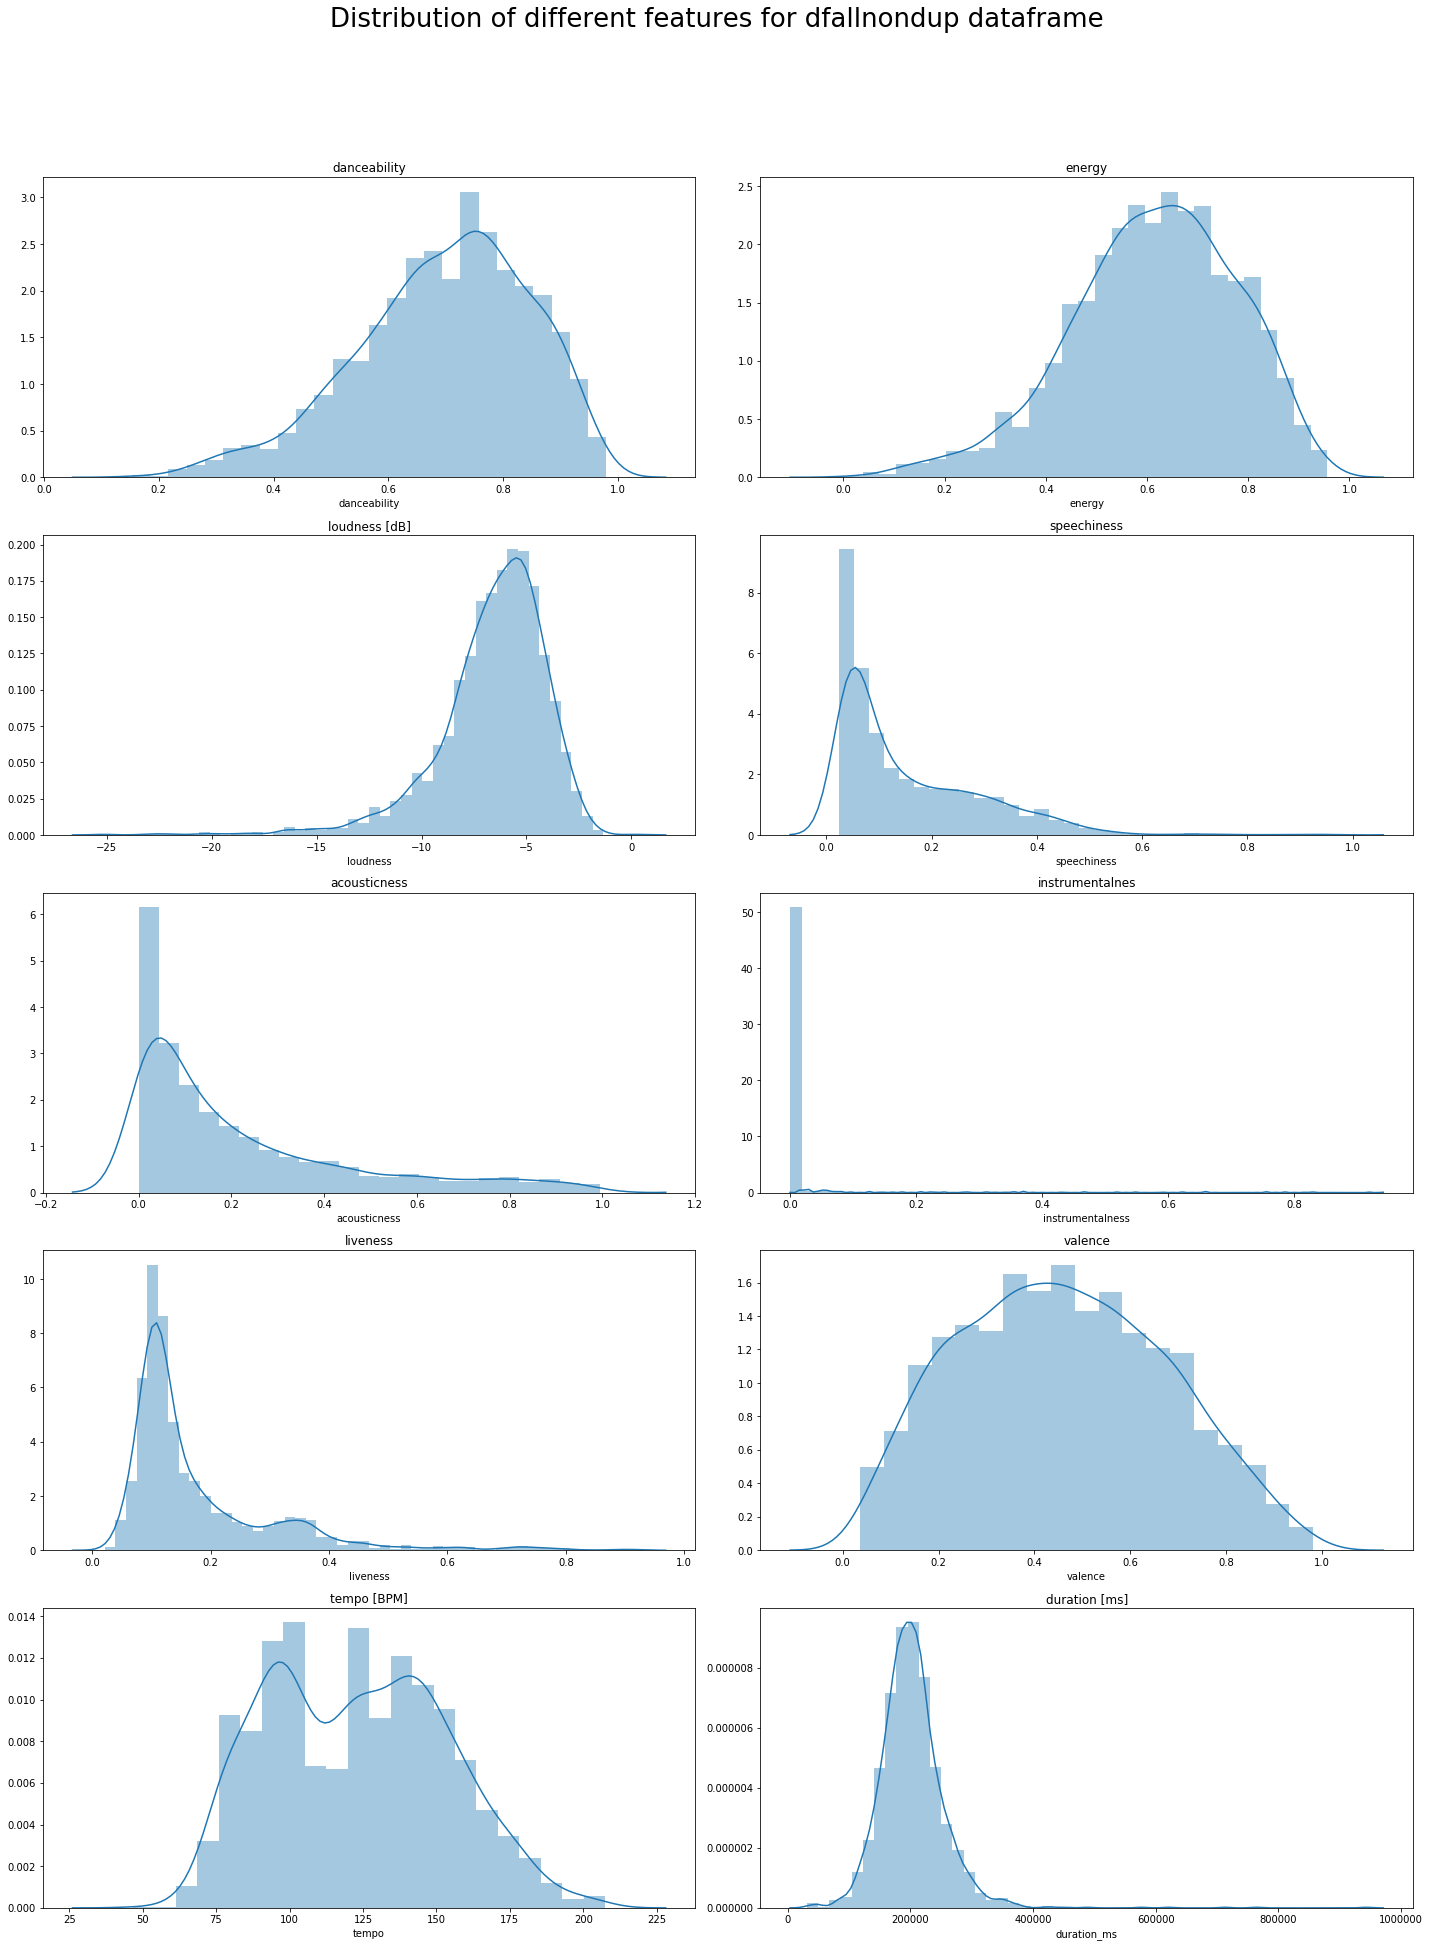

In [11]:
f1, ((ax1, ax2),(ax3,ax4), (ax5, ax6), (ax7,ax8),(ax9,ax10)) = plt.subplots(5, 2,figsize=(20, 25))                                  

plt.sca(ax1)
sns.distplot(dfallnondup['danceability'])
plt.title('danceability')

plt.sca(ax2)
sns.distplot(dfallnondup['energy'])
plt.title('energy')

plt.sca(ax3)
sns.distplot(dfallnondup['loudness'])
plt.title('loudness [dB]')

plt.sca(ax4)
sns.distplot(dfallnondup['speechiness'])
plt.title('speechiness')

plt.sca(ax5)
sns.distplot(dfallnondup['acousticness'])
plt.title('acousticness')

plt.sca(ax6)
sns.distplot(dfallnondup['instrumentalness'])
plt.title('instrumentalnes')

plt.sca(ax7)
sns.distplot(dfallnondup['liveness'])
plt.title('liveness')

plt.sca(ax8)
sns.distplot(dfallnondup['valence'])
plt.title('valence')

plt.sca(ax9)
sns.distplot(dfallnondup['tempo'])
plt.title('tempo [BPM]')

plt.sca(ax10)
sns.distplot(dfallnondup['duration_ms'])
plt.title('duration [ms]')


f1.suptitle('Distribution of different features for dfallnondup dataframe', fontsize=26,y=1.08)
plt.tight_layout()

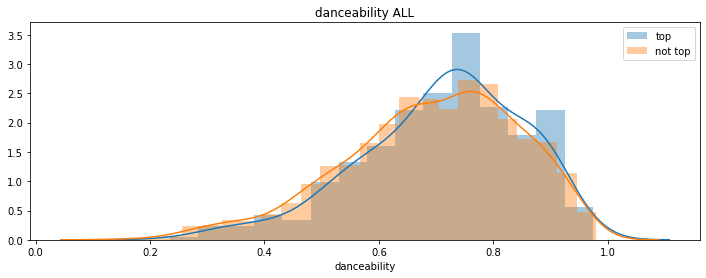

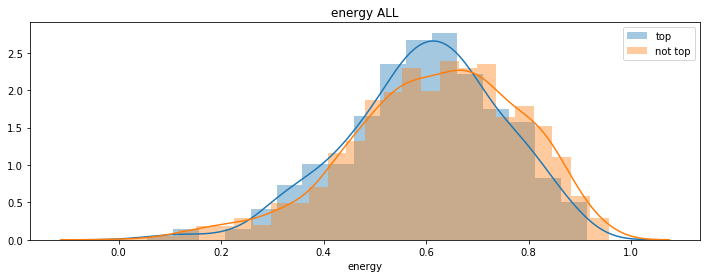

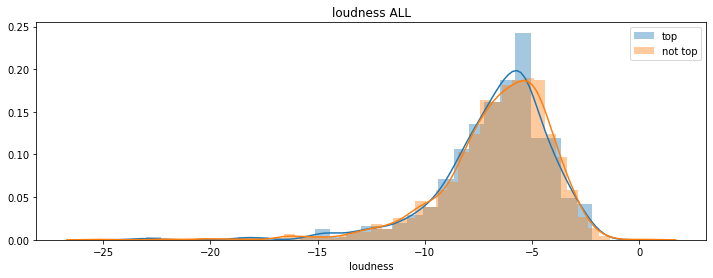

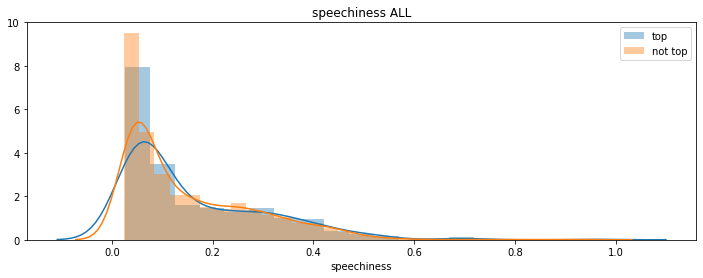

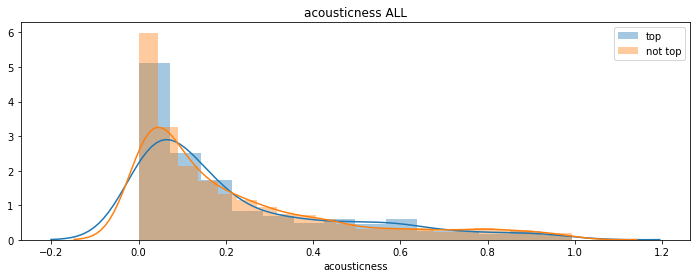

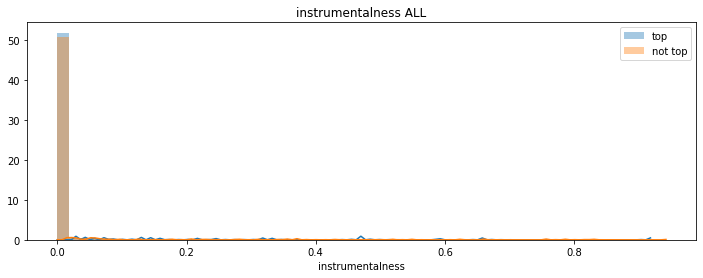

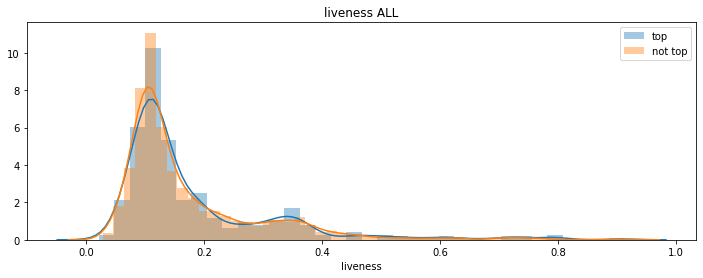

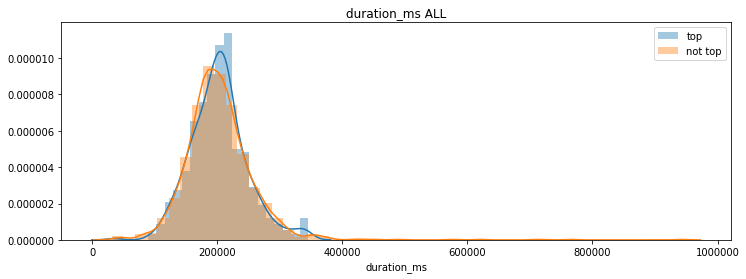

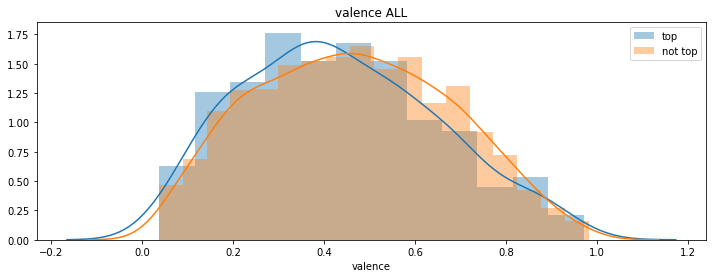

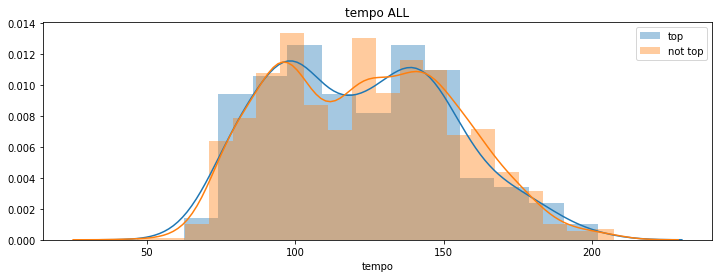

In [12]:
features=['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','duration_ms','valence','tempo',]

for feat in features:
    f1, (ax1) = plt.subplots(1, 1,figsize=(12, 4))                                  

    plt.sca(ax1)
    df = dfallnondup[dfallnondup.top == 1]
    sns.distplot(df[feat], label='top')
    plt.title(feat + ' ALL')
    df = dfallnondup[dfallnondup.top == 0]
    sns.distplot(df[feat],label='not top')
    plt.legend()

Certain features related to probability are:'speechiness', 'acousticness','liveness','instrumentalness'. In order to visualize them we will see if there is a trend that emerges from plotting best position vs average of these values.
As seen below there is no clear pattern emerging.

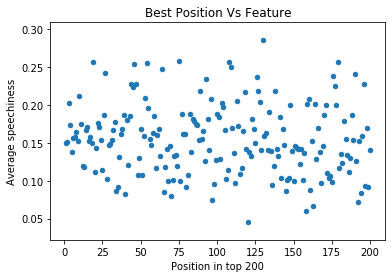

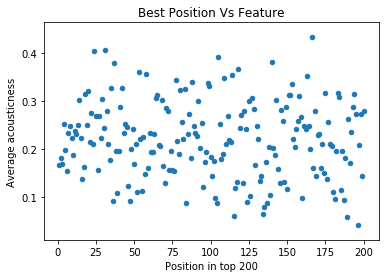

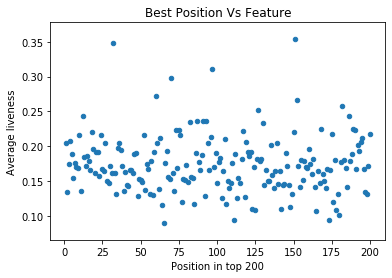

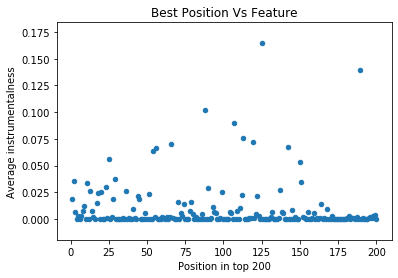

In [13]:
probfeat=['speechiness', 'acousticness','liveness','instrumentalness']
for feat in probfeat: 
    dfplot=pd.DataFrame(dfallnondup.groupby('Position')[feat].mean())
    dfplot.reset_index().plot(kind='scatter',x='Position',y=feat)
    plt.title('Best Position Vs Feature')
    plt.ylabel('Average '+ feat)
    plt.xlabel('Position in top 200')

We will use another approach of plotting for every distinct measure of the feature the average best position of songs with that feature 

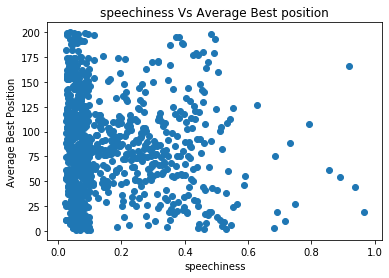

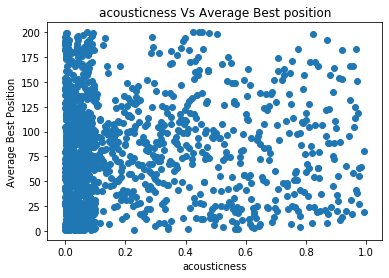

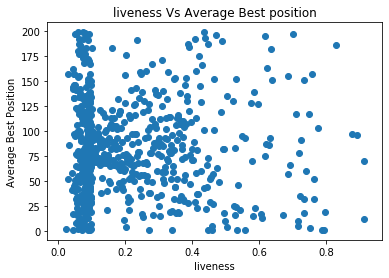

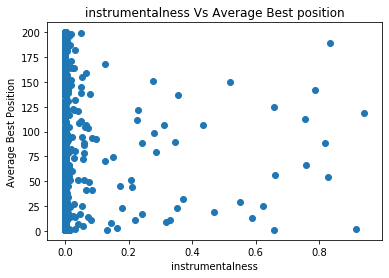

In [14]:
probfeat=['speechiness', 'acousticness','liveness','instrumentalness']
for feat in probfeat: 
    arrayf=dfallnondup[feat].unique()
    arrayf.sort()
    avgmc=[]
    for i in arrayf:
        datatemp=dfallnondup[dfallnondup[feat]==i]
        meantmp=datatemp['Position'].mean()
        avgmc.append(meantmp)
    plt.figure()
    plt.scatter(arrayf,avgmc)
    plt.title(feat+ ' Vs Average Best position')
    plt.xlabel(feat)
    plt.ylabel('Average Best Position')     

These second set of graphs do not give us much information either. Most of the data is condensed in a specific region below 0.2. So although it appears as though certain percentage of liveness favor better position it may just be because there is less data point in that neighborhood.

The lack of a clear correlation between features and position in the charts suggests that making an accurate prediction may be difficult. In the next section several models are built to obtain a reliable result, but the metrics confirmed a certain difficulty to reach very good performance.

Text(0.5, 1.0, 'boxplot of best position grouped by key')

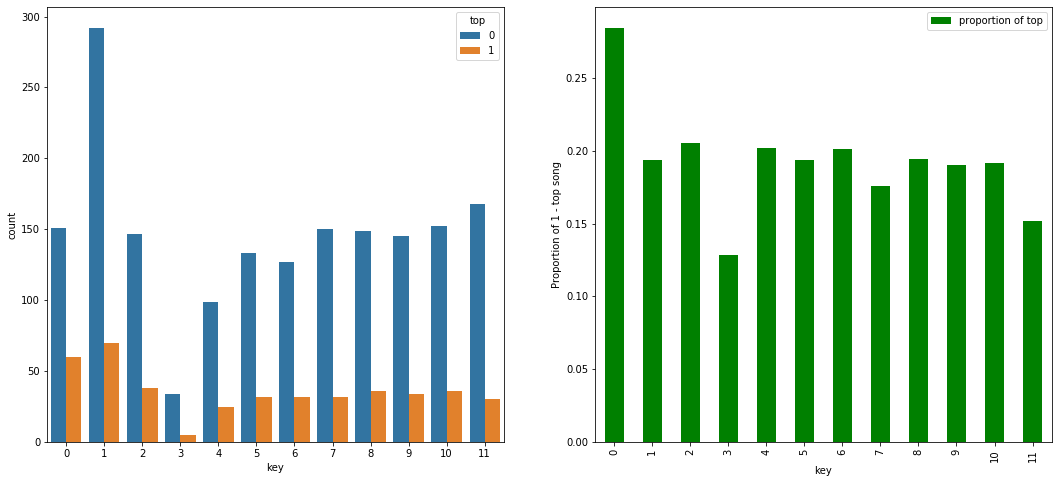

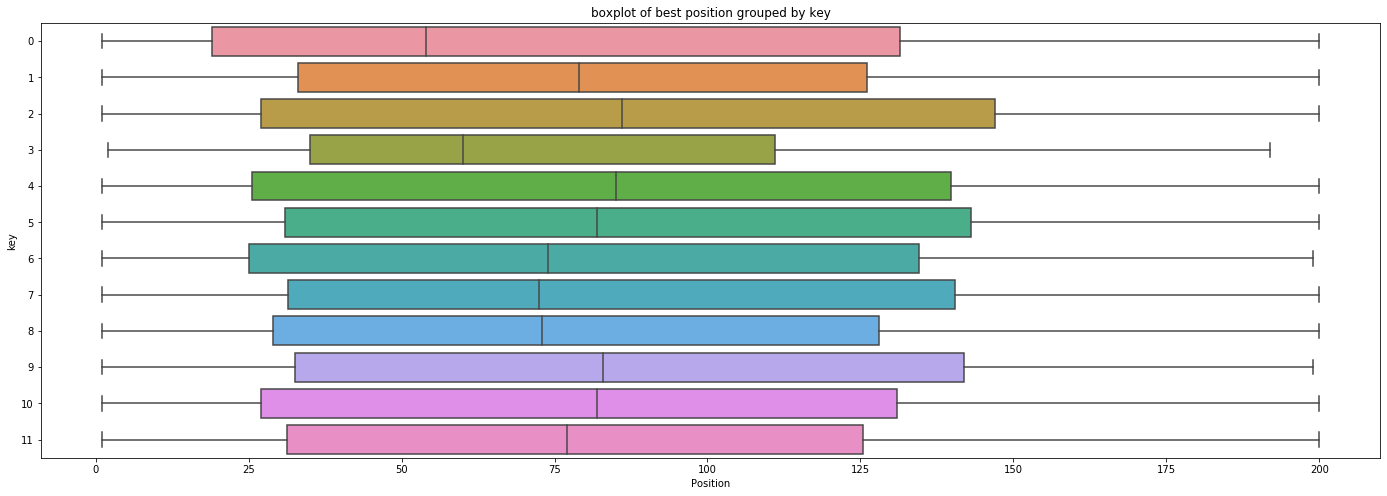

In [15]:
### Discrete Variables Bar plot
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
plt.axes(axs[0])
axs[0] = sns.countplot(x='key', hue='top', data=dfallnondup)
plt.axes(axs[1])
axs[1] = dfallnondup.groupby('key')['top'].mean().plot(kind='bar', color='g')
plt.legend(['proportion of top'])
plt.ylabel('Proportion of 1 - top song')


plt.figure(figsize=(24, 8))
sns.boxplot(x='Position', y='key', data=dfallnondup, orient='h')
plt.title('boxplot of best position grouped by key')



In [16]:
dfallnondup[dfallnondup['key']==-1]
#this cell confirms there is no 'undetected' key which couldn't be identified by spotify- which is good news since it means no missing key values

,Position,Track Name,Artist,Streams,URL,danceability,energy,key,loudness,mode,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,week,year,top


## Classification Model

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix,average_precision_score, f1_score

## 1st iteration: a successful song is defined as one entering the top 10% of the chart

### Random forest

using all data dfall without oversamplig

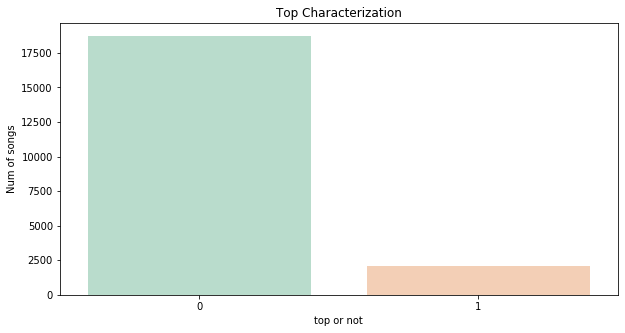

In [18]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=dfall, x='top',palette="Pastel2")
ax.set(xlabel='top or not', ylabel='Num of songs')
plt.title("Top Characterization")
plt.show()

Accuracy Score: 0.9076923076923077
Recall Score: 0.22115384615384615
Precision Score: 0.6052631578947368
F1 Score: 0.323943661971831


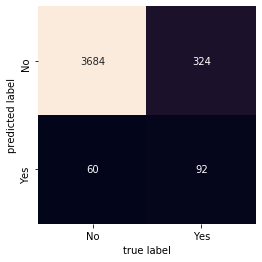

In [19]:
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature','duration_ms']            
X=dfall[features]
y=dfall['top']
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)

clf= RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))
print("F1 Score:",f1_score(y_test,y_pred,labels=[1,0]))

Since the database is strongly unbalanced, the model is repeated with oversampling

df1count  1664
df0count  14976
df1_over  14976
Accuracy Score: 0.7557692307692307
Recall Score: 0.8173076923076923
Precision Score: 0.265625
F1 Score: 0.40094339622641506


(2.0, 0.0)

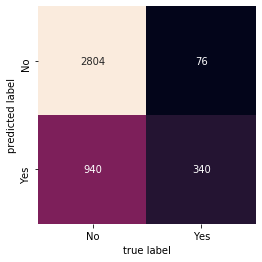

In [20]:
X_train, X_test, y_train, y_test = train_test_split(dfall, dfall["top"], stratify=dfall["top"],test_size=0.2)
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature','duration_ms']               
# Divide by class
df0 = X_train[X_train['top'] == 0]
df1 = X_train[X_train['top'] == 1]
df1count=df1.shape[0]
df0count=df0.shape[0]
print('df1count ',df1count)
print('df0count ',df0count)
df1_over = df1.sample(df0count, replace=True)
print('df1_over ', df1_over.shape[0])
X_trainb=pd.concat([df1_over, df0], ignore_index=True) #new training Xb balanced
y_train=X_trainb['top']
X_trainb=X_trainb[features]
X_test=X_test[features]
#retry random forest classifier
clf = RandomForestClassifier()
clf.fit(X_trainb, y_train)  

y_pred=clf.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))
print("F1 Score:",f1_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

Applying oversampling in the database improves the recall score of the model, which is the most interesting one since the goal is to predict which songs will be successful.

### SVM
using dfall without oversampling

Accuracy Score: 0.9021634615384615
Recall Score: 0.038461538461538464
Precision Score: 0.6956521739130435
F1 Score: 0.07289293849658314


(2.0, 0.0)

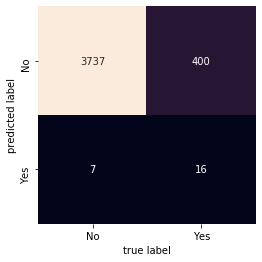

In [21]:
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature','duration_ms']            
X=dfall[features]
scaler =StandardScaler()
X= pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
y=dfall['top']
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)

clf = svm.SVC()
clf.fit(X_train, y_train)  

y_pred=clf.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))
print("F1 Score:",f1_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

svm with oversampling

df1count  1664
df0count  14976
df1_over  14976
Accuracy Score: 0.7310096153846154
Recall Score: 0.7788461538461539
Precision Score: 0.23982235381199113
F1 Score: 0.366723259762309


(2.0, 0.0)

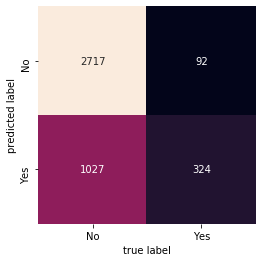

In [22]:
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature','duration_ms']        
df_scaled = dfall.copy()
scaler =StandardScaler()
df_scaled[features] = scaler.fit_transform(df_scaled[features])

X_train, X_test, y_train, y_test = train_test_split(df_scaled, df_scaled["top"], stratify=df_scaled["top"],test_size=0.2)
            
# Divide by class
df0 = X_train[X_train['top'] == 0]
df1 = X_train[X_train['top'] == 1]
df1count=df1.shape[0]
df0count=df0.shape[0]
print('df1count ',df1count)
print('df0count ',df0count)
df1_over = df1.sample(df0count, replace=True)
print('df1_over ', df1_over.shape[0])
X_trainb=pd.concat([df1_over, df0], ignore_index=True) #new training Xb balanced
y_train=X_trainb['top']
X_trainb=X_trainb[features]
X_test=X_test[features]


#retry svm
clf = svm.SVC()
clf.fit(X_trainb, y_train)  

y_pred=clf.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))
print("F1 Score:",f1_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

df1count  1664
df0count  14976
df1_over  14976
Accuracy Score: 0.5596153846153846
Recall Score: 0.5865384615384616
Precision Score: 0.12815126050420167
F1 Score: 0.21034482758620687


(2.0, 0.0)

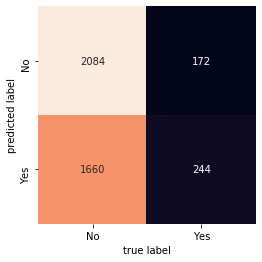

In [23]:
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature','duration_ms']        
df_scaled = dfall.copy()
scaler =StandardScaler()
df_scaled[features] = scaler.fit_transform(df_scaled[features])

X_train, X_test, y_train, y_test = train_test_split(df_scaled, df_scaled["top"], stratify=df_scaled["top"],test_size=0.2)
            
# Divide by class
df0 = X_train[X_train['top'] == 0]
df1 = X_train[X_train['top'] == 1]
df1count=df1.shape[0]
df0count=df0.shape[0]
print('df1count ',df1count)
print('df0count ',df0count)
df1_over = df1.sample(df0count, replace=True)
print('df1_over ', df1_over.shape[0])
X_trainb=pd.concat([df1_over, df0], ignore_index=True) #new training Xb balanced
y_train=X_trainb['top']
X_trainb=X_trainb[features]
X_test=X_test[features]


#retry svm
clf = svm.SVC(kernel='linear')
clf.fit(X_trainb, y_train)  

y_pred=clf.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))
print("F1 Score:",f1_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

### Logistic Regression

without oversampling 

Accuracy Score: 0.9
Recall Score: 0.0
Precision Score: 0.0
F1 Score: 0.0


C:\Users\ydi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ydi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(2.0, 0.0)

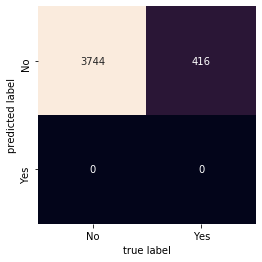

In [24]:
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature']            
X=dfall[features]
y=dfall['top']
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)
logReg = LogisticRegression(max_iter=10000)
logReg.fit(X_train, y_train)
y_pred=predictions = logReg.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))
print("F1 Score:",f1_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

with oversampling

df1count  1664
df0count  14976
df1_over  14976
Accuracy Score: 0.5581730769230769
Recall Score: 0.6298076923076923
Precision Score: 0.13463514902363824
F1 Score: 0.2218458933107536


(2.0, 0.0)

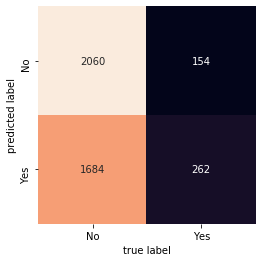

In [25]:
X_train, X_test, y_train, y_test = train_test_split(dfall, dfall["top"], stratify=dfall["top"],test_size=0.2)
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature']            
# Divide by class
df0 = X_train[X_train['top'] == 0]
df1 = X_train[X_train['top'] == 1]
df1count=df1.shape[0]
df0count=df0.shape[0]
print('df1count ',df1count)
print('df0count ',df0count)
df1_over = df1.sample(df0count, replace=True)
print('df1_over ', df1_over.shape[0])
X_trainb=pd.concat([df1_over, df0], ignore_index=True) #new training Xb balanced
y_train=X_trainb['top']
X_trainb=X_trainb[features]
X_test=X_test[features]
#retry logistic
logReg = LogisticRegression(max_iter=10000)
logReg.fit(X_trainb, y_train)
y_pred=predictions = logReg.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))
print("F1 Score:",f1_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

After applying three different models, it can be observed that none of them has very good performance.
Reasoning on the possible causes of these results, the team realized that the definition of success was not appropriate; therefore, a new one is defined and the analysis is repeated. 

## 2nd iteration --> Looking at songs as individuals: distinct songs, ranked a hit if reached top at least once in 2018 or 2019

After realizing that the same song appeared multiple times in different positions in the database, the available data have been updated keeping just one appearance per song in the highest position it reached. 

In [26]:
#number of distinct track name in 2019 200 weekly charts
dfall['Track Name'].unique().size

2177

In [27]:
dfalltop=dfall[dfall['top']==1]
dfalltop['Track Name'].unique().size

430

Sort in ascending the postion, so ony keep lower (so best on top 200) of each unique song and drop duplicates

In [28]:
dfallnondup=dfall.sort_values('Position', ascending=True).drop_duplicates('Track Name')
dfallnondup.index = np.arange(len(dfallnondup))
dfallnondup.head()

,Position,Track Name,Artist,Streams,URL,danceability,energy,key,loudness,mode,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,week,year,top
0,1,rockstar,Post Malone,9855305,https://open.spotify.com/track/7wGoVu4Dady5GV0...,0.577,0.522,5,-6.594,0,...,audio_features,7wGoVu4Dady5GV0Sv4UIsx,spotify:track:7wGoVu4Dady5GV0Sv4UIsx,https://api.spotify.com/v1/tracks/7wGoVu4Dady5...,https://api.spotify.com/v1/audio-analysis/7wGo...,218320,4,1,2018,1
1,1,Nice For What,Drake,19830250,https://open.spotify.com/track/1cTZMwcBJT0Ka3U...,0.567,0.913,8,-6.471,1,...,audio_features,1cTZMwcBJT0Ka3UJPXOeeN,spotify:track:1cTZMwcBJT0Ka3UJPXOeeN,https://api.spotify.com/v1/tracks/1cTZMwcBJT0K...,https://api.spotify.com/v1/audio-analysis/1cTZ...,210926,4,15,2018,1
2,1,Circles,Post Malone,12719540,https://open.spotify.com/track/21jGcNKet2qwijl...,0.695,0.762,0,-3.497,1,...,audio_features,21jGcNKet2qwijlDFuPiPb,spotify:track:21jGcNKet2qwijlDFuPiPb,https://api.spotify.com/v1/tracks/21jGcNKet2qw...,https://api.spotify.com/v1/audio-analysis/21jG...,215280,4,37,2019,1
3,1,Better Now,Post Malone,21229827,https://open.spotify.com/track/7dt6x5M1jzdTEt8...,0.680,0.578,10,-5.804,1,...,audio_features,7dt6x5M1jzdTEt8oCbisTK,spotify:track:7dt6x5M1jzdTEt8oCbisTK,https://api.spotify.com/v1/tracks/7dt6x5M1jzdT...,https://api.spotify.com/v1/audio-analysis/7dt6...,231267,4,17,2018,1
4,1,Lover,Taylor Swift,12784772,https://open.spotify.com/track/1dGr1c8CrMLDpV6...,0.359,0.543,7,-7.582,1,...,audio_features,1dGr1c8CrMLDpV6mPbImSI,spotify:track:1dGr1c8CrMLDpV6mPbImSI,https://api.spotify.com/v1/tracks/1dGr1c8CrMLD...,https://api.spotify.com/v1/audio-analysis/1dGr...,221307,4,34,2019,1


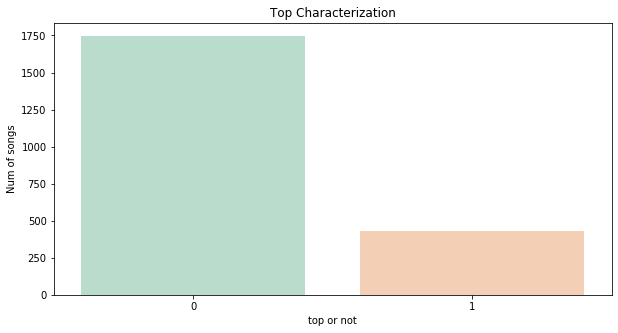

In [29]:
## visualizing distribution of top and not top unique songs
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=dfallnondup, x='top',palette="Pastel2")
ax.set(xlabel='top or not', ylabel='Num of songs')
plt.title("Top Characterization")
plt.show()

#### Random Forest without oversampling

Accuracy Score: 0.786697247706422
Recall Score: 0.046511627906976744
Precision Score: 0.26666666666666666
F1 Score: 0.0792079207920792


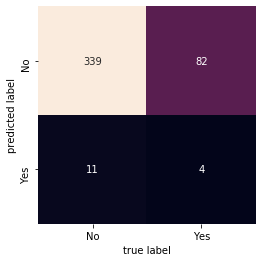

In [30]:
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature','duration_ms']            
X=dfallnondup[features]
y=dfallnondup['top']
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)

clf= RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))
print("F1 Score:",f1_score(y_test,y_pred,labels=[1,0]))

#### Random Forest with oversampling

df1count  344
df0count  1397
df1_over  1397
Accuracy Score: 0.7798165137614679
Recall Score: 0.11627906976744186
Precision Score: 0.3333333333333333
F1 Score: 0.1724137931034483


(2.0, 0.0)

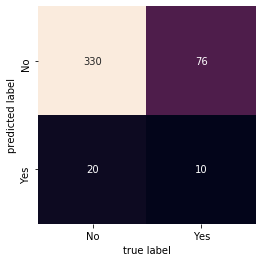

In [31]:
X_train, X_test, y_train, y_test = train_test_split(dfallnondup, dfallnondup["top"], stratify=dfallnondup["top"],test_size=0.2)
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature','duration_ms']               
# Divide by class
df0 = X_train[X_train['top'] == 0]
df1 = X_train[X_train['top'] == 1]
df1count=df1.shape[0]
df0count=df0.shape[0]
print('df1count ',df1count)
print('df0count ',df0count)
df1_over = df1.sample(df0count, replace=True)
print('df1_over ', df1_over.shape[0])
X_trainb=pd.concat([df1_over, df0], ignore_index=True) #new training Xb balanced
y_train=X_trainb['top']
X_trainb=X_trainb[features]
X_test=X_test[features]
#retry random forest classifier
clf = RandomForestClassifier()
clf.fit(X_trainb, y_train)  

y_pred=clf.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))
print("F1 Score:",f1_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

#### Random Forest with Cross-Validation
hyperparameters to tune: min_samples_leaf and max depth


In [32]:
leaf=[1,2,3,4,5]
depths = list(np.linspace(1, 30, 30, endpoint=True))
depths.append(None)

X_train, X_test, y_train, y_test = train_test_split(dfallnondup, dfallnondup["top"], stratify=dfallnondup["top"],test_size=0.2)
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature','duration_ms']               
# Divide by class
df0 = X_train[X_train['top'] == 0]
df1 = X_train[X_train['top'] == 1]
df1count=df1.shape[0]
df0count=df0.shape[0]
print('df1count ',df1count)
print('df0count ',df0count)
df1_over = df1.sample(df0count, replace=True)
print('df1_over ', df1_over.shape[0])
X_trainb=pd.concat([df1_over, df0], ignore_index=True) #new training Xb balanced
y_train=X_trainb['top']
X_trainb=X_trainb[features]
X_test=X_test[features]
#retry random forest classifier

scorerf= []
for l in leaf:
    ltmp=[]
    for d in depths:
        clf = RandomForestClassifier(max_depth=d, min_samples_leaf=l)
        ltmp.append(np.mean(cross_val_score(clf, X_trainb, y_train, cv=5, scoring='f1')))
    scorerf.append(ltmp)
        
        

df1count  344
df0count  1397
df1_over  1397


In [33]:
scorerf=np.array(scorerf)
maxindex = scorerf.argmax()
from numpy import unravel_index
ind=unravel_index(scorerf.argmax(), scorerf.shape)
print('scorerf: ', np.amax(scorerf))
print('index: ', ind)

scorerf:  0.9455972547815131
index:  (0, 23)


The first index relates to the min_leaf parameter and the second the max_depth parameter. As seen in the cell below, it is bes to use min_leaf of 1 and max_depth of 30.

In [34]:
leafvar = leaf[ind[0]]
print('leaf', leafvar)
depthvar = depths[ind[1]]
print('depth', depthvar)

leaf 1
depth 24.0


Here we are executing the final random forest with oversampling and tuned parameters

Accuracy Score: 0.7912844036697247
Recall Score: 0.06976744186046512
Precision Score: 0.35294117647058826
F1 Score: 0.11650485436893203


(2.0, 0.0)

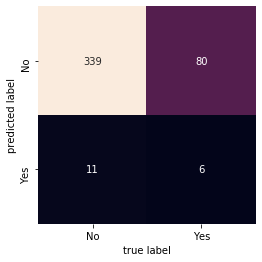

In [35]:
clf = RandomForestClassifier(min_samples_leaf=leafvar, max_depth=depthvar)
clf.fit(X_trainb, y_train)  

y_pred=clf.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))
print("F1 Score:",f1_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

A cross validation is used to avoid overfitting in the model, and to tune the parameters of the model. However, it is important to note that the metrics obtained are not the best ones in absolute terms, but the best ones when averaging the results of different database split selection and not selecting a single specific one.

### SVM
without oversampling

Accuracy Score: 0.8027522935779816
Recall Score: 0.0
Precision Score: 0.0
F1 Score: 0.0


C:\Users\ydi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ydi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(2.0, 0.0)

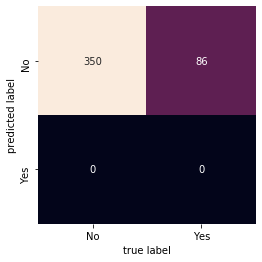

In [36]:
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature','duration_ms']            
X=dfallnondup[features]
scaler =StandardScaler()
X= pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
y=dfallnondup['top']
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)

clf = svm.SVC()
clf.fit(X_train, y_train)  

y_pred=clf.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))
print("F1 Score:",f1_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

with oversampling

df1count  344
df0count  1397
df1_over  1397
Accuracy Score: 0.6422018348623854
Recall Score: 0.5
Precision Score: 0.27564102564102566
F1 Score: 0.3553719008264463


(2.0, 0.0)

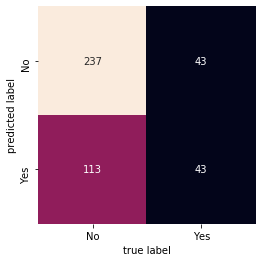

In [37]:
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature','duration_ms']        
df_scaled = dfallnondup.copy()
scaler =StandardScaler()
df_scaled[features] = scaler.fit_transform(df_scaled[features])

X_train, X_test, y_train, y_test = train_test_split(df_scaled, df_scaled["top"], stratify=df_scaled["top"],test_size=0.2)
            
# Divide by class
df0 = X_train[X_train['top'] == 0]
df1 = X_train[X_train['top'] == 1]
df1count=df1.shape[0]
df0count=df0.shape[0]
print('df1count ',df1count)
print('df0count ',df0count)
df1_over = df1.sample(df0count, replace=True)
print('df1_over ', df1_over.shape[0])
X_trainb=pd.concat([df1_over, df0], ignore_index=True) #new training Xb balanced
y_train=X_trainb['top']
X_trainb=X_trainb[features]
X_test=X_test[features]


#retry svm
clf = svm.SVC()
clf.fit(X_trainb, y_train)  

y_pred=clf.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))
print("F1 Score:",f1_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

Notes: evidently balancing out the dataset was necessary

#### SVM cross-validation hyperparameter tuning
Let's see of we can tune our svm model by changing kernels and paramers such as C or degree

In [38]:
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature','duration_ms']        
df_scaled = dfallnondup.copy()
scaler =StandardScaler()
df_scaled[features] = scaler.fit_transform(df_scaled[features])

X_train, X_test, y_train, y_test = train_test_split(df_scaled, df_scaled["top"], stratify=df_scaled["top"],test_size=0.2)
            
# Divide by class
df0 = X_train[X_train['top'] == 0]
df1 = X_train[X_train['top'] == 1]
df1count=df1.shape[0]
df0count=df0.shape[0]
print('df1count ',df1count)
print('df0count ',df0count)
df1_over = df1.sample(df0count, replace=True)
print('df1_over ', df1_over.shape[0])
X_trainb=pd.concat([df1_over, df0], ignore_index=True) #new training Xb balanced
y_train=X_trainb['top']
X_trainb=X_trainb[features]
X_test=X_test[features]

scores=[]
scoresrbf=[]
scoresig=[]
scorespoly=[]

#retry svm cross validation
for i in [1,10,10^2,10^3,10^4,10^5]:
    clf = svm.SVC(kernel='linear', C=i)
    scores.append(np.mean(cross_val_score(clf, X_trainb, y_train, cv=5, scoring='f1')))
    clfrbf=svm.SVC(kernel='rbf', C=i)
    scoresrbf.append(np.mean(cross_val_score(clfrbf, X_trainb, y_train, cv=5, scoring='f1')))
    clfsig = svm.SVC(kernel='sigmoid', C=i)
    scoresig.append(np.mean(cross_val_score(clfsig, X_trainb, y_train, cv=5, scoring='f1')))
for d in [1,2,3,4,5,6]:
    clfpoly=svm.SVC(kernel='poly', degree=d)
    scorespoly.append(np.mean(cross_val_score(clfpoly, X_trainb, y_train, cv=5, scoring='f1')))


"""
print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)
"""

df1count  344
df0count  1397
df1_over  1397


'\nprint("Accuracy Score:",accuracy_score(y_test,y_pred))\nprint("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))\nprint("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))\n\nmat = confusion_matrix(y_test, y_pred)\ns1=sns.heatmap(mat.T, square=True, annot=True, fmt=\'d\', cbar=False,\n          xticklabels=[\'No\',\'Yes\'],\n          yticklabels=[\'No\',\'Yes\'] )\nplt.xlabel(\'true label\')\nplt.ylabel(\'predicted label\')\nbottom, top = s1.get_ylim()\ns1.set_ylim(bottom + 0.5, top - 0.5)\n'

In [39]:
print('score: ',scores)
print('scorerbf: ',scoresrbf)
print('scorepoly: ',scorespoly)
print('scoresig: ', scoresig )

score:  [0.5874280343550607, 0.5869381296631536, 0.5867383331595923, 0.5869381296631536, 0.5869349718666929, 0.5867294377655565]
scorerbf:  [0.6798142109160541, 0.7834622953506292, 0.774888273624919, 0.7777628992011344, 0.795882890120574, 0.7977210071583057]
scorepoly:  [0.5881552862507533, 0.6224172443430003, 0.6626640145112767, 0.6800576922499648, 0.6248062452030724, 0.5673162435702697]
scoresig:  [0.467813659630981, 0.4825346308371663, 0.47841382012284434, 0.4748266735267731, 0.4772868776457491, 0.48185060189090284]


evidenty we are better off sticking with the default rbf kernel, and it appears as though the highest C was the most favorable. Let's test the final performance with this kernel and C value

Accuracy Score: 0.6032110091743119
Recall Score: 0.29069767441860467
Precision Score: 0.18248175182481752
f1score:  0.2242152466367713


(2.0, 0.0)

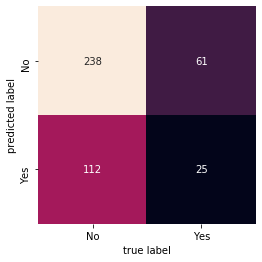

In [40]:
#retry svm
i=10^5
clf=svm.SVC(kernel='rbf', C=i)
clf.fit(X_trainb, y_train)  

y_pred=clf.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))
print("f1score: ", 2/(1/recall_score(y_test,y_pred,labels=[1,0])+1/precision_score(y_test,y_pred,labels=[1,0])))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)


### Logistic regression
without oversampling

Accuracy Score: 0.8027522935779816
Recall Score: 0.0
Precision Score: 0.0
F1 Score: 0.0


C:\Users\ydi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ydi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(2.0, 0.0)

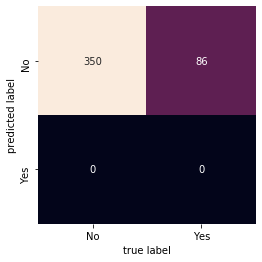

In [41]:
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature']            
X=dfallnondup[features]
y=dfallnondup['top']
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)
logReg = LogisticRegression(max_iter=10000)
logReg.fit(X_train, y_train)
y_pred=predictions = logReg.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))
print("F1 Score:",f1_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

with oversampling

df1count  344
df0count  1397
df1_over  1397
Accuracy Score: 0.5481651376146789
Recall Score: 0.5465116279069767
Precision Score: 0.22926829268292684
F1 Score: 0.3230240549828179


(2.0, 0.0)

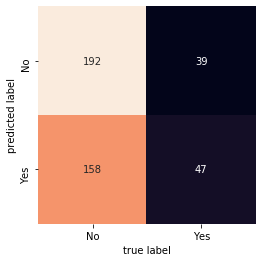

In [42]:
X_train, X_test, y_train, y_test = train_test_split(dfallnondup, dfallnondup["top"], stratify=dfallnondup["top"],test_size=0.2)
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature']            
# Divide by class
df0 = X_train[X_train['top'] == 0]
df1 = X_train[X_train['top'] == 1]
df1count=df1.shape[0]
df0count=df0.shape[0]
print('df1count ',df1count)
print('df0count ',df0count)
df1_over = df1.sample(df0count, replace=True)
print('df1_over ', df1_over.shape[0])
X_trainb=pd.concat([df1_over, df0], ignore_index=True) #new training Xb balanced
y_train=X_trainb['top']
X_trainb=X_trainb[features]
X_test=X_test[features]
#retry logistic
logReg = LogisticRegression(max_iter=10000)
logReg.fit(X_trainb, y_train)
y_pred=predictions = logReg.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))
print("F1 Score:",f1_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

df1count  344
df0count  1397
df1_over  1397
Accuracy Score: 0.5527522935779816
Recall Score: 0.5697674418604651
Precision Score: 0.23671497584541062
F1 Score: 0.3344709897610921


(2.0, 0.0)

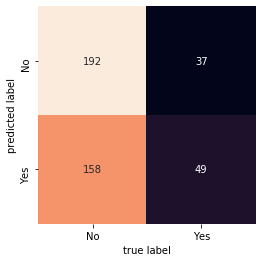

In [43]:
# Add a cross validation for logistic regression
X_train, X_test, y_train, y_test = train_test_split(dfallnondup, dfallnondup["top"], stratify=dfallnondup["top"],test_size=0.2)
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature']            
# Divide by class
df0 = X_train[X_train['top'] == 0]
df1 = X_train[X_train['top'] == 1]
df1count=df1.shape[0]
df0count=df0.shape[0]
print('df1count ',df1count)
print('df0count ',df0count)
df1_over = df1.sample(df0count, replace=True)
print('df1_over ', df1_over.shape[0])
X_trainb=pd.concat([df1_over, df0], ignore_index=True) #new training Xb balanced
y_train=X_trainb['top']
X_trainb=X_trainb[features]
X_test=X_test[features]
#retry logistic

logReg = LogisticRegressionCV(Cs=np.logspace(-1, 6, 8), cv=5, scoring="f1",max_iter=10000)
logReg.fit(X_trainb, y_train)
y_pred=predictions = logReg.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))
print("F1 Score:",f1_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

## Regression Model

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , classification_report, mean_squared_error, r2_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix,average_precision_score

### Feature Engineering for Regression

Besides keeping all the music quality features we used in out classifier model, we try to understand which kinds of time-series data could be introduced to our regressor.  

Normally, the Spotify users may try to listen the songs which has already been popular. Therefore, we introduce the new features recording the stream in the last 5 appearances in the list and the position in the last list.  

However, if the popular song stays too long on the top lists, the user may consider it “out-of-fashion” and streams less. In order to take this case into consideration, we introduced two other features: 

Week-count: count how many times the song has been in the top 200 list 
Week-prev: when was the last time the song appeared in the top 200 list.  
Week: current week of the estimation, working together with the week-prev, we could observe if the song has felt out of the list in the past period. 

### Step 1 Feature Selection & Dynamic Features

In [45]:
dfall_fe = dfall.copy()
dfall_fe = dfall_fe.drop(columns = ['URL', 'uri','track_href','analysis_url','type','Track Name'])
dfall_fe_id_values = dfall_fe.id.unique().tolist()
cdff = ['counts','index_prev','week_prev','pos_prev','stream_prev']
vdff = np.empty((len(dfall_fe_id_values),len(cdff)))
vdff[:] = np.nan
dfFeature = pd.DataFrame(vdff, 
                         index =dfall_fe_id_values, columns = cdff)
dfall_fe['hist'] = [0]*len(dfall_fe.index)
dfall_fe['new'] = [0]*len(dfall_fe.index)

In [46]:
for i in range(dfall_fe.shape[0]):
    if np.isnan(dfFeature.at[dfall_fe.id[i],'counts']):
        dfall_fe.at[i,'new'] = 1
        dfall_fe.at[i,'hist'] = 1
        dfFeature.at[dfall_fe.id[i],'counts'] = 1
        dfFeature.at[dfall_fe.id[i],'stream_prev'] = dfall_fe.at[i,'Streams']
        dfFeature.at[dfall_fe.id[i],'stream_log1'] = dfall_fe.at[i,'Streams']
        dfFeature.at[dfall_fe.id[i],'stream_log2'] = dfall_fe.at[i,'Streams']
        dfFeature.at[dfall_fe.id[i],'stream_log3'] = dfall_fe.at[i,'Streams']
        dfFeature.at[dfall_fe.id[i],'stream_log4'] = dfall_fe.at[i,'Streams']
        dfall_fe.at[i,'week_prev'] = 0
        dfall_fe.at[i,'stream_prev'] = 0
        dfall_fe.at[i,'pos_prev'] = 200
        
    else:
        dfFeature.at[dfall_fe.id[i],'counts'] += 1
        dfall_fe.at[i,'week_prev'] = dfFeature.at[dfall_fe.id[i],'week_prev']
        dfall_fe.at[i,'stream_prev'] = dfFeature.at[dfall_fe.id[i],'stream_prev']
        dfall_fe.at[i,'stream_prev'] = dfFeature.at[dfall_fe.id[i],'stream_prev']
        dfall_fe.at[i,'pos_prev'] = dfFeature.at[dfall_fe.id[i],'pos_prev']
        dfall_fe.at[i,'hist'] = dfFeature.at[dfall_fe.id[i],'counts']
    dfFeature.at[dfall_fe.id[i],'index_prev'] = i
    dfFeature.at[dfall_fe.id[i],'week_prev'] = dfall_fe.at[i,'week']
    dfFeature.at[dfall_fe.id[i],'stream_log4'] = dfFeature.at[dfall_fe.id[i],'stream_log3']
    dfFeature.at[dfall_fe.id[i],'stream_log3'] = dfFeature.at[dfall_fe.id[i],'stream_log2']
    dfFeature.at[dfall_fe.id[i],'stream_log2'] = dfFeature.at[dfall_fe.id[i],'stream_log1']
    dfFeature.at[dfall_fe.id[i],'stream_log1'] = dfFeature.at[dfall_fe.id[i],'stream_prev']
    dfFeature.at[dfall_fe.id[i],'stream_prev'] = dfall_fe.at[i,'Streams']
    dfFeature.at[dfall_fe.id[i],'pos_prev'] = dfall_fe.at[i,'Position']
    dfall_fe.at[i,'stream_avg'] = 1/5*(dfall_fe.at[i,'Streams'] + dfFeature.at[dfall_fe.id[i],'stream_prev']
                                      + dfFeature.at[dfall_fe.id[i],'stream_log1']+ dfFeature.at[dfall_fe.id[i],'stream_log2']
                                      + dfFeature.at[dfall_fe.id[i],'stream_log3']+ dfFeature.at[dfall_fe.id[i],'stream_log4'])
    

### Step 2 Feature Augmentation

In [47]:
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo','new','week','week_prev','pos_prev','stream_prev','duration_ms']    
X_orig = dfall_fe[features]
from sklearn.preprocessing import StandardScaler
x = X_orig.values #returns a numpy array
std_scaler = StandardScaler()
x_scaled = std_scaler.fit_transform(x)

X_scaled = pd.DataFrame(x_scaled, columns = features) 

In [48]:
def generate_polynormial_features_set(X_scaled, k ):
    x_scaled = X_scaled.to_numpy()
    features = X_scaled.columns.tolist()
    for order in range(2,k+1):
        features_tmp = features
        for i in range(len(features)):
            features_tmp[i]= features[i]+'_'+str(order)
            x_tmp = x_scaled**order
        X_tmp = pd.DataFrame(x_tmp, columns = features_tmp) 
        if order == 2:
            X_poly = X_tmp
        else:
            X_poly = pd.concat([X_poly, X_tmp], axis=1).reindex(X_poly.index)
    return X_poly

### Position Prediction – Use Regression to Classify the Top Songs 

One of the limitations in our classification model is that the unbalanced dataset will generate the estimation bias. Although we could use some sampling approaches to generate a balanced dataset, new bias could be introduced during the process.  

As the classification object “Top” is based on the value “Position”, one of the possible solutions is to change the classification problem to a regression problem on “Position”. The classification will be done based on the predicted “Position” value.  

Different from the approach in our classification model, as the position is a time-dependent value, the model will be week-based. Some dynamic features will be introduced to improve the accuracy of the time series approach.  

#### Linear Regression

In [49]:
X = X_scaled
y = dfall['Position']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
y_pred_train = regr.predict(X_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Test Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Train Mean squared error: %.2f'
      % mean_squared_error(y_train, y_pred_train))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [ -0.93400081   1.18646102   0.18086987  -0.23824331   0.31211134
   0.76001938  -0.1261568    0.05608319   0.40249569   0.49944433
  -0.4175163  -36.96056879   3.9079533   -4.86812708  54.43129125
  -4.75617464   1.06211438]
Test Mean squared error: 970.46
Train Mean squared error: 949.76
Coefficient of determination: 0.71


#### Polynomial Regression

In [50]:
X_poly = generate_polynormial_features_set(X_scaled, 4)
X = pd.concat([X_scaled, X_poly], axis=1).reindex(X_scaled.index)
y = dfall['Position']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
y_pred_train = regr.predict(X_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Test Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Train Mean squared error: %.2f'
      % mean_squared_error(y_train, y_pred_train))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [-1.03782060e+00  1.59325283e+00 -3.91934401e-01  9.12941771e-02
 -3.05368485e-02  2.37675573e-01 -3.67387147e-01  2.87863433e+00
  1.06670646e+00  1.98627346e+00  2.35349123e-01 -1.25997075e-01
 -6.19191857e-01  4.23054788e-01  4.75563689e+01 -3.19104931e+01
  8.92098343e-01  4.90669052e-02  8.48084503e-01  4.23513093e+00
 -5.02803476e-01  1.20678041e-02  6.25073438e-02  9.40573656e-01
 -1.38451180e+00 -7.75465365e-01  1.32286989e+00  1.04454621e+00
 -2.85650797e-01  2.92211808e+00 -1.38284980e+00  6.83728793e+00
  1.28914561e+01  2.26010348e-01  1.56642419e-01 -9.49128525e-03
  2.39946162e-01 -2.47628346e-01 -3.53059031e-02  8.47931301e-02
  2.40454624e-01  1.56299117e-01  2.46978428e-01 -7.24203881e-01
 -3.08551407e-01 -7.73602409e-01  1.63969210e+00 -1.07013396e-01
 -4.69752135e+00 -1.92066235e+00 -4.03356308e-02  9.52059602e-02
 -7.67962287e-02 -1.58560739e+00 -2.75732315e-02  2.60202826e-02
 -3.19642870e-03 -1.87895591e-01 -4.86301258e-03 -2.61173848e-02
 -1.41439

#### Full features regression

In [51]:
features_sqrt = features
for i in range(len(features)):
    features_sqrt[i]= features[i]+'_sqrt'

x_sqrt = np.sqrt(np.abs(x_scaled))
X_sqrt = pd.DataFrame(x_sqrt, columns = features_sqrt) 

features_sin = features
for i in range(len(features)):
    features_sin[i]= features[i]+'_sin'

x_sin = np.sin(x_scaled)
X_sin = pd.DataFrame(x_sin, columns = features_sin) 

features_cos = features
for i in range(len(features)):
    features_cos[i]= features[i]+'_cos'

x_cos = np.cos(x_scaled)
X_cos = pd.DataFrame(x_cos, columns = features_cos) 

In [52]:
X = pd.concat([X_scaled, X_poly, X_sqrt, X_sin, X_cos], axis=1).reindex(X_scaled.index)
y = dfall['Position']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
y_pred_train = regr.predict(X_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Test Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Train Mean squared error: %.2f'
      % mean_squared_error(y_train, y_pred_train))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [-4.39770542e+01 -1.45368423e+01  1.69508148e+02  2.91277986e+00
  1.06836190e-01 -1.93203690e+01  2.17610694e+02  5.81174811e+00
  2.37616819e+01 -5.07307499e+00  1.14014677e+01 -1.74327489e-01
  5.37793478e+02 -5.12568459e+02  5.00379378e+01 -6.64110309e+01
 -1.06487498e+00 -2.70920644e+01  1.56283040e+00 -8.19763400e+01
  8.27024193e-02 -4.22204081e-02  1.53246842e+00 -2.75977652e+01
 -1.45617441e+00  5.60054101e+00 -2.69731248e+00 -1.60532186e+01
 -3.95221783e-01  6.30500737e+02 -6.91006964e+02  1.62961094e+02
  2.71310447e+01  5.52805533e-01  6.03860203e+00  2.04206072e+00
 -2.42781368e+01 -3.22764233e-01  1.23521196e-01  2.50729235e+00
 -3.61348015e+01  1.32467031e-01 -5.19961670e+00  1.54713555e-01
 -1.87559043e+00 -1.07034367e+00 -7.42878847e+01  7.44121377e+01
 -3.45163079e+00 -3.77080224e+00 -1.37585364e-02  2.18536931e+00
  1.86998248e-01  4.65724906e+00 -4.57368493e-02 -9.10345383e-02
 -3.32702249e-01  6.24804052e+00 -3.53050232e-03  6.10937238e-01
  1.60690

#### Classification based on Regression

Accuracy Score: 0.915625
Recall Score: 0.6543504171632897
Precision Score: 0.9
F1 Score: 0.7577639751552796


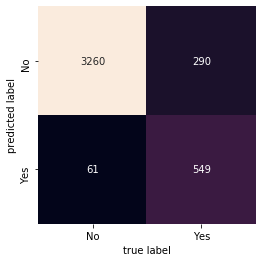

In [53]:
y_test_clf = pd.DataFrame(y_test)
y_test_clf['top'] = np.where(y_test_clf['Position']<dfall.Position.quantile(0.2), 1, 0)
y_pred_clf = pd.DataFrame(data = y_pred, columns = ['Position'])
y_pred_clf['top'] = np.where(y_pred_clf['Position']<dfall.Position.quantile(0.2), 1, 0)

mat = confusion_matrix(y_test_clf['top'], y_pred_clf['top'])
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

print("Accuracy Score:",accuracy_score(y_test_clf['top'],y_pred_clf['top']))
print("Recall Score:",recall_score(y_test_clf['top'],y_pred_clf['top'],labels=[1,0]))
print("Precision Score:",precision_score(y_test_clf['top'],y_pred_clf['top'],labels=[1,0]))
print("F1 Score:",f1_score(y_test_clf['top'],y_pred_clf['top'],labels=[1,0]))

In [59]:
list_cof = abs(regr.coef_)
topfeature = sorted( [(x,i) for (i,x) in enumerate(list_cof)], reverse=True )[:15]
features_list = list(X.columns)
print("The most important features are:")
for feature in topfeature:
    print (features_list[feature[1]])

The most important features are:
week_prev_sqrt_sin_cos
week_sqrt_sin_cos
week_prev_2
week_2
week_sqrt_sin
week
week_prev_sqrt_sin
week_prev
pos_prev_sqrt_sin_cos
acousticness
acousticness_sqrt_sin
key_sqrt_sin_cos
key_sqrt_sin
key
pos_prev_2


## Regression based on Streams

Based on the current business model of Spotify, streaming number is the decisive factor for the singer's profit. We could therefore predict the future number of streams as the estimative indicator for the singer's profit from spotify. 

The problem could be defined as a regression problem with continious output variable rather than binary-classfication. Therefore, We need to choose different models with different feature set for this problem. The coefficient of determination is chosen as the measure on the performance of our regressor. 

### Linear Regression

In [60]:
X = X_scaled
y = dfall['Streams']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
y_pred_train = regr.predict(X_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Test Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Train Mean squared error: %.2f'
      % mean_squared_error(y_train, y_pred_train))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))


Coefficients: 
 [ 4.85716288e+04 -5.76470135e+04 -6.65624532e+03  2.59199996e+04
  2.79711825e+03 -2.69528981e+04 -1.50628856e+04  8.94733413e+02
  8.65619017e+03 -1.69484520e+03  9.02044192e+03  1.07007748e+06
  1.18211557e+04  9.35056813e+03 -9.72399485e+04  1.74313540e+06
 -1.28134105e+04]
Test Mean squared error: 1811067715729.95
Train Mean squared error: 1592201629426.63
Coefficient of determination: 0.57


### Polynormial Regression

In [61]:
X_poly = generate_polynormial_features_set(X_scaled, 4)
X = pd.concat([X_scaled, X_poly], axis=1).reindex(X_scaled.index)
y = dfall['Streams']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
y_pred_train = regr.predict(X_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Test Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Train Mean squared error: %.2f'
      % mean_squared_error(y_train, y_pred_train))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [ 3.98894955e+04 -5.33159737e+04  6.84937782e+04  3.17124340e+04
 -4.47144289e+01 -1.14917418e+04  3.39175715e+04 -3.16403963e+04
 -4.29031944e+04 -6.96786729e+04  1.22600126e+04  2.35632637e+03
 -4.42376325e+05  4.36405270e+05 -7.02084143e+04  1.43653459e+06
 -5.14660136e+03  4.20941480e+02 -3.04803330e+04 -1.11808474e+05
  9.95995989e+03  1.76706174e+01 -4.33939875e+04 -9.97937189e+03
  1.87910592e+04  4.95023516e+04 -3.08910196e+04 -3.40357778e+04
  5.34208041e+03  2.07005318e+04  1.01059634e+05 -3.00689758e+05
 -1.55978079e+05 -9.89380487e+03 -5.86369427e+03 -3.32992693e+02
 -4.17410652e+04 -5.01735668e+03 -5.16976496e+01  2.24896528e+04
 -1.50836202e+04 -2.12748181e+03 -4.42784782e+03  2.77165308e+04
 -1.08649507e+04  1.44674768e+04  1.76079349e+05 -3.04339904e+05
 -1.12200753e+05  2.98283344e+04 -4.91100608e+02 -3.04969407e+03
  9.25788511e+02  3.77632666e+04 -1.02572191e+03  3.81009217e+01
 -2.65562691e+03  5.20179417e+03  6.66669617e+01 -6.47850020e+02
  3.43440

### Regression on Full features

In [62]:
X = pd.concat([X_scaled, X_poly, X_sqrt, X_sin, X_cos], axis=1).reindex(X_scaled.index)
y = dfall['Streams']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
y_pred_train = regr.predict(X_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Test Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Train Mean squared error: %.2f'
      % mean_squared_error(y_train, y_pred_train))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [ 1.29630310e+06  3.16066399e+05  7.02003035e+05  1.39691811e+05
  6.98172485e+02 -5.20826648e+05  1.66400403e+05  1.44973732e+05
  1.18895767e+05 -3.51987971e+05 -1.28201737e+06  3.87718127e+03
 -2.99632212e+07  3.51725761e+07  2.89147656e+07  2.52394081e+06
  4.47777766e+04  2.51203960e+05  6.96146897e+04  1.59730934e+06
 -2.10773640e+04 -2.75909729e+02 -1.67259060e+05 -1.85992190e+06
  2.03594211e+04 -3.33276006e+05  1.47248951e+06  3.14401997e+06
  8.79004282e+03 -2.36245103e+07  1.47178031e+07 -5.47221407e+07
 -9.94907769e+05  1.76475933e+04 -1.87257227e+05 -5.65927912e+04
 -1.38944698e+05 -2.18646282e+04  8.07209290e+02  1.25430148e+05
  3.78724488e+04 -2.60139844e+03  5.95182241e+04  6.28359420e+04
  1.76498227e+05  2.38052845e+04  4.29054565e+06 -5.27248190e+06
 -4.34012903e+06  1.65989949e+05 -8.28446590e+03 -3.75855957e+04
 -1.40627319e+04 -7.41812586e+04 -2.16329883e+03 -5.94909439e+02
 -1.39809714e+04  9.49007456e+04  8.16250000e+01 -8.45718750e+02
 -9.51236